In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

before running, run `build_subdfs.sh` and `build_df.sh`

In [3]:
def get_metric_df(df, metric, params):
    
    # transpose dataframe
    df = df.transpose()
    
    # index into values of metric
    metric_df = df.xs(key=metric, level=len(params), axis=1).xs(key='value', level=len(params), axis=1)

    # add step as column
    metric_df.reset_index(inplace=True)
    metric_df.rename(columns={'index': 'step'}, inplace=True)

    # make run name a column, and remove index from end 
    metric_df = metric_df.melt(id_vars=['step'])
    for i, param in enumerate(params):
        metric_df.rename(columns={f'variable_{i}': param}, inplace=True)

    #remove nan values
    metric_df = metric_df[~metric_df['value'].isnull().values]

    return metric_df

# Load Data

In [9]:
# load build df from path 
data_path = "exp/default/walker_walk/walker_walk_4_df.pkl"
df_walker = pd.read_pickle(data_path)

In [10]:
# load build df from path 
data_path = "exp/default/cartpole_balance/cartpole_balance_4_df.pkl"
df_cartpole = pd.read_pickle(data_path)

In [11]:
df = pd.concat([df_cartpole, df_walker], keys=['cartpole_balance', 'walker_walk'])

In [12]:
df.index[0]

('cartpole_balance',
 '4',
 'uniform',
 '1',
 '12345',
 'train/episode_reward',
 'value')

In [13]:
params = ['environment', 'n_teachers', 'teacher_selection', 'query_sampling', 'seed']

In [14]:
metric = 'train/true_episode_reward'

In [15]:
ep_reward_df = get_metric_df(df, metric, params)

In [16]:
ep_reward_df

,step,environment,n_teachers,teacher_selection,query_sampling,seed,value
0,0,cartpole_balance,4,uniform,1,12345,0.000000
1,1000,cartpole_balance,4,uniform,1,12345,275.280457
1001,2000,cartpole_balance,4,uniform,1,12345,299.312683
2001,3000,cartpole_balance,4,uniform,1,12345,238.320618
3001,4000,cartpole_balance,4,uniform,1,12345,193.273895
...,...,...,...,...,...,...,...
1119210,495000,walker_walk,4,uniform,1,51234,61.347347
1119236,496000,walker_walk,4,uniform,1,51234,64.546532
1119251,497000,walker_walk,4,uniform,1,51234,67.110367
1119267,498000,walker_walk,4,uniform,1,51234,61.885006


In [17]:
ep_reward_df['n_teachers'] = pd.to_numeric(ep_reward_df['n_teachers'])
ep_reward_df.rename(columns={'value': 'reward'}, inplace=True)

In [18]:
query_map = {
    "1": "disagreement",
    "6": "similarity",
    "7": "hybrid"
}

In [19]:
ep_reward_df['query_sampling'] = ep_reward_df['query_sampling'].replace(query_map)

# Mean Episode Returns

## Max Beta vs Uniform

In [44]:
environments = ['cartpole_balance', 'walker_walk']
teach_selects = ['uniform', 'max_beta']
max_steps = {}

for env in environments:
    max_step = ep_reward_df[
                (ep_reward_df['query_sampling'] == "disagreement") & 
                (ep_reward_df['environment'] == env)
    ]['step'].max()
    max_steps[env] = max_step
        

In [45]:
max_steps

{'cartpole_balance': 249000, 'walker_walk': 499000}

In [46]:
mean_std_final_returns = {}
for env in environments:
    mean_std_final_returns[env] = {}
    for teach_select in teach_selects:
        final_returns = ep_reward_df[
                    (ep_reward_df['query_sampling'] == "disagreement") & 
                    (ep_reward_df['environment'] == env) &
                    (ep_reward_df['step'] == max_steps[env]) & 
                    (ep_reward_df['teacher_selection'] == teach_select)
        ]['reward']
        mean_std_final_returns[env][teach_select] = (final_returns.mean(), final_returns.std())

In [47]:
mean_std_final_returns

{'cartpole_balance': {'uniform': (396.4774002075195, 337.6236514060669),
  'max_beta': (756.0242523193359, 333.59320860993347)},
 'walker_walk': {'uniform': (258.7339691162109, 186.45810119945543),
  'max_beta': (889.6564819335938, 94.91977255126847)}}

# Query Sampling

In [52]:
query_samplings = list(query_map.values())

In [53]:
mean_std_final_returns = {}
for env in environments:
    mean_std_final_returns[env] = {}
    for query_sampling in query_samplings:
        final_returns = ep_reward_df[
                    (ep_reward_df['query_sampling'] == query_sampling) & 
                    (ep_reward_df['environment'] == env) &
                    (ep_reward_df['step'] == max_steps[env]) & 
                    (ep_reward_df['teacher_selection'] == 'max_beta')
        ]['reward']
        mean_std_final_returns[env][query_sampling] = (final_returns.mean(), final_returns.std())

In [54]:
mean_std_final_returns

{'cartpole_balance': {'disagreement': (756.0242523193359, 333.59320860993347),
  'similarity': (580.1917572021484, 261.7116280065256),
  'hybrid': (793.9773681640625, 196.39556483858908)},
 'walker_walk': {'disagreement': (889.6564819335938, 94.91977255126847),
  'similarity': (950.0926513671875, 20.632588216500757),
  'hybrid': (938.552294921875, 70.81504653821487)}}

# Plot Learning Curves

### Max Beta vs Uniform

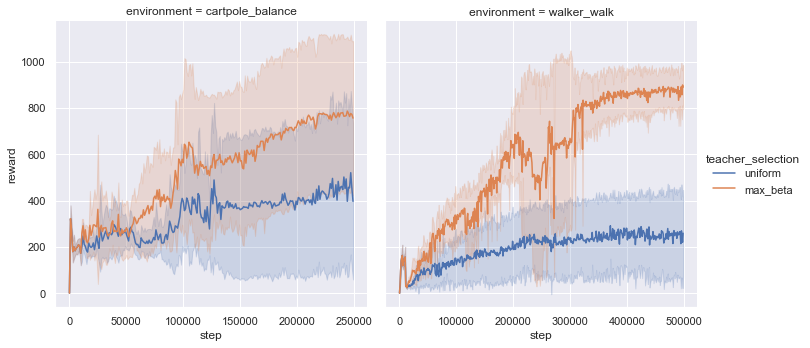

In [21]:
g = sns.relplot(
    data=ep_reward_df[ep_reward_df['query_sampling'] == "disagreement"], x='step', y='reward', 
    hue='teacher_selection', col='environment', ci='sd', kind='line', facet_kws={'sharex': False}
)

### Similarity Queries

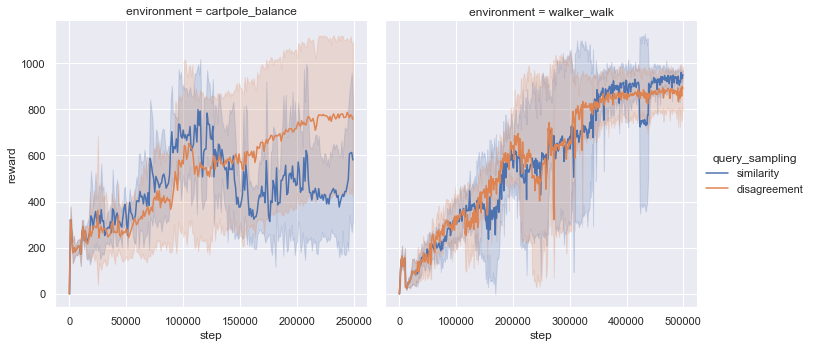

In [24]:
g = sns.relplot(
    data=ep_reward_df[
        (ep_reward_df['teacher_selection'] == "max_beta") & (ep_reward_df['query_sampling'] != "hybrid")
    ], 
    x='step', y='reward', hue='query_sampling', col='environment', ci='sd', 
    kind='line', facet_kws={'sharex': False}
)

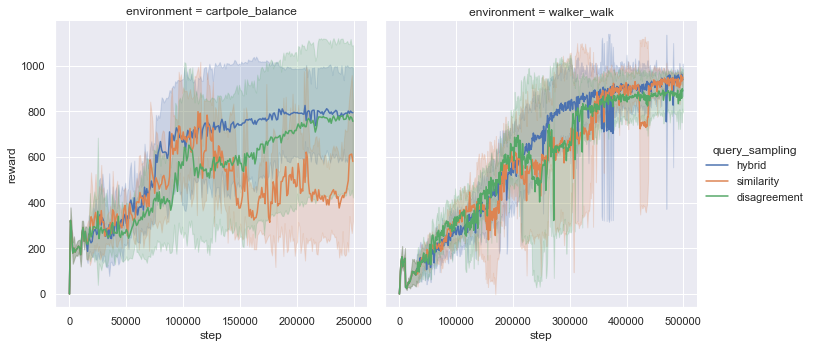

In [26]:
g = sns.relplot(
    data=ep_reward_df[ep_reward_df['teacher_selection'] == "max_beta"], x='step', y='reward', 
    hue='query_sampling', col='environment', ci='sd', kind='line', facet_kws={'sharex': False}
)


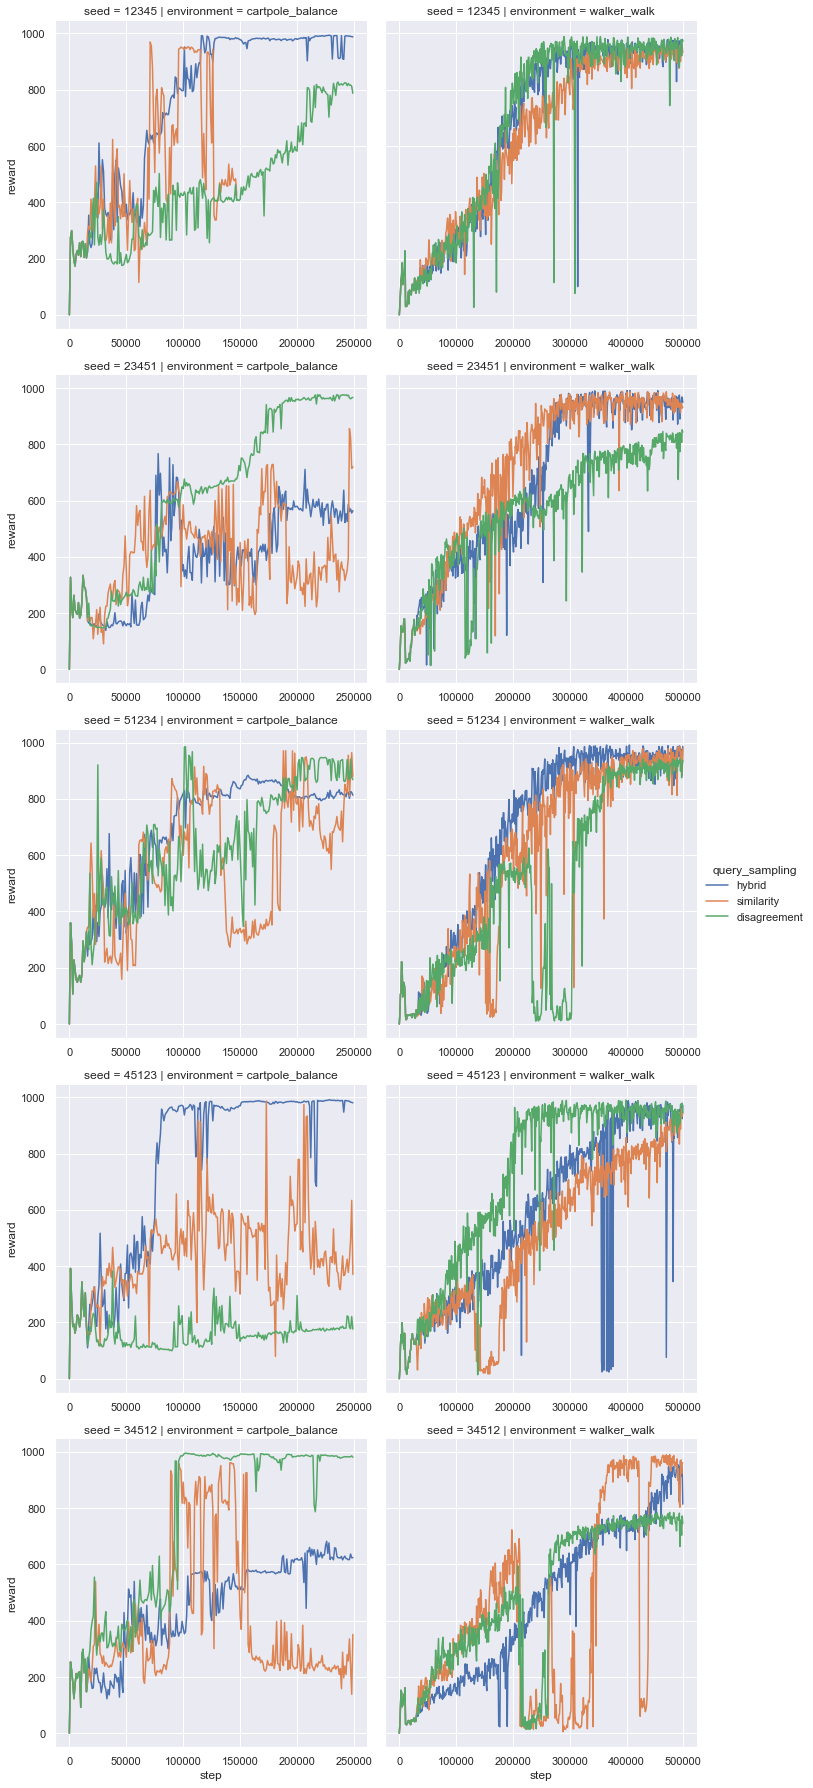

In [28]:
g = sns.relplot(
    data=ep_reward_df[ep_reward_df['teacher_selection'] == "max_beta"], x='step', y='reward', 
    hue='query_sampling', col='environment', row='seed', ci=None, kind='line', facet_kws={'sharex': False},
    estimator=None
)